# Background and Motivation

Standard deep learning networks consist of two basic parts: large, (usually) trainable, operational layers, and activation functions. The purpose of the operational layer depends on the type, and some common examples include linear or dense layers, convolusional layers, and various flavors of normalization layers. However, these operational layers are by and large composed of linear operations, and thus no matter how complex a model is in terms of number and size of layers, the output will always be a mostly linear function of the output. In a mostly nonlinear world, this is an issue. 

Enter the activation functions, which apply any function to the output of its preceding layer. Two of the most common examples are the sigmoid/tanh classifier functions, and the ReLU function. Choosing which activation functions to apply is no easier than deciding which operational layers to include and how to structure them. However, in the case of the layers, there is quite a bit more room for error: if the size and parameters of the layer (and sometimes even the type) differ from the ideal version of the model, the optimization process will still make your model as accurate as possible, and it may even yield passable results. This is not the case with activation functions, as they are hard-coded into the model and have no leniancy with how they shape the output space of a layer. Perhaps the model can still learn around these errors, but this choice can still be a cause of frustration. This begs the question, what if the activation functions could be learned as well? What if, in addition to the standard linear weights, the optimizer trained a set of nonlinear weights as well?

There may be a way. In the year 1715, Brook Taylor proved that every function $f(x)$ could be represented by a power series of the form

$$
\sum_{n=0}^{\infty} \frac{f^{(n)}(a)}{n!}(x - a)^{n},
$$

where $f^{(n)}$ is the *n*th derivative of $f$, and $a$ is the point the series is centered about. In the world of computation, infinite summations are impractical, so we will also define

$$
P(f, m, a) = \sum_{n=0}^{m} \frac{f^{(n)}(a)}{n!}(x - a)^{n}
$$

as the $m$th-order approximation polynomial of $f(x)$ centered about $a$. As a general rule, higher values of $m$ yield better approximations, but lower values are easier to compute. As an example, consider the sigmoid function

$$
\sigma = \frac{1}{1+e^{-x}}.
$$

The third-order approximation centered about $x=0$ is given by

$$
P(\sigma, 3, 0) = \frac{1}{2} +  \frac{1}{4} x - \frac{1}{48} x^{3}.
$$

How does it look? The below cell will compute and plot the sigmoid function, as well as two approximation polynomials of order 3 and 11.

<class 'sympy.core.mul.Mul'>


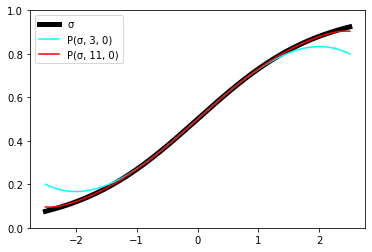

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import Symbol, exp, Poly

# sympy allows us to define functions symbolically
# as we will later see, this gives us a number of advantages for series computation over other methods

x = Symbol('x')
sigmoid = 1. / (1 + exp(-x))
print(type(sigmoid))

# however, for actual numerical evaluation this method is slow
# therefore we will also define an array version

AXIS_SIZE = 1001 # the extra one allows for clean numbers
t = np.linspace(-2.5, 2.5, AXIS_SIZE).reshape((-1, 1)) # the use of reshape here is to allow for matrix algebra
np_sigmoid = 1. / (1. + np.exp(-t))

# sympy gives us a means to compute a series with a single call
# the all_coeffs function ensures we include terms whose coefficient is zero

s_3 = Poly(sigmoid.series(x, 0, 3 + 1).removeO()).all_coeffs() # the extra one here ensures our degree is included
s_11 = Poly(sigmoid.series(x, 0, 11 + 1).removeO()).all_coeffs()

# for plotting, we cast our coefficients to numpy
# note that sympy orders its polynomials with the degree term first, whereas we will be using the opposite convention

c_3 = np.flip(s_3).reshape((-1, 1))
c_11 = np.flip(s_11).reshape((-1, 1))

# note that the .series method DOES NOT include terms with coefficients of zero
# for lower terms, this is rectified by casting to a polynomial with the ._all_coeffs method
# however, if the degree term is zero, it is dropped and a degree - 1 order polynomial is returned
# this would be an issue if we used an even order approximation
# therefore, we add an extra step to check

def _order_check(c, n):
    if len(c) != n + 1:
        c = np.append(c, 0.)
    
    return c.reshape((-1, 1))

c_3 = _order_check(c_3, 3)
c_11 = _order_check(c_11, 11)

# next, we calculate our power terms
pows = np.array(range(12))
T_11 = np.power(t, pows)
T_3 = T_11[:, :4]

# and finally the actual values of our polynomial approximations
p_3 = T_3 @ c_3
p_11 = T_11 @ c_11

#plotting
plt.ylim((0., 1.))
plt.plot(t, np_sigmoid, color='black', linewidth=5, label='σ')
plt.plot(t, p_3, color='cyan', label='P(σ, 3, 0)')
plt.plot(t, p_11, color='red', label='P(σ, 11, 0)')
plt.legend()

Within the subdomain [-1, 1] both polynomials are extremely similar to the true sigmoid, after which the cubic approximation quickly splits off, while the 11th order appriximation remains close until reaching $\pm$2. Before getting into the logistics of the nonlinear weights, this is a good time to remember that every function has a disk of convergence: the subdomain of the reals in which the power series converges to the function. That is to say, higher order approximations are closer to the true value. Outside the DoC, every term that is added to the polynomial makes the approximation worse. Therefore, it is important to ensure that the input space of an approximation polynomial is a subset of the DoC. In the case of $\sigma(x)$ centered about $x=0$, the radius of convergence is 2, corresponding to a DoC of [-2, 2], with the best approximations happening in [-1, 1].

Now, given the above equations, it's clear that

$$
P(n, 0) = \omega_{0} + \omega_{1}x + \frac{\omega_{2}}{4}x^{2} + \frac{\omega_{3}}{6}x^{3} + O(x^{4})
$$

is a third order approximation for *some* function, and the actual value of $\mathbf{\omega}$ determines what that function is, and therefore a simple gradient descent of the form

$$
\mathbf{\omega} \rightarrow \mathbf{\omega} - \alpha \nabla_{\omega} J
$$

can converge to *any* continuous function in the DoC, where $\alpha$ is our learning rate and $J$ is some cost function. But wait, the coefficients of the series grow small *extremely* quickly. For example, if $\alpha=0.001$ $J=1$, and our 11th order term coefficient for the sigmoid approximation is $691/319334400 \approx 2.16$e-6, then a single gradient descent step will make $\omega_{11}$ *three orders of magnitude larger than it's supposed to be*! Instead, we need to change each variable with its own learning rate that decreases by the inverse factorial as well,

$$
\omega_{n} \rightarrow \omega_{n} - \frac{\alpha}{n!} \frac{\partial J}{\partial \omega_n}.
$$

Seems simple enough. Let's try it:

Initial Cost: 5981.301223178458, Final Cost: 139.2951451569548


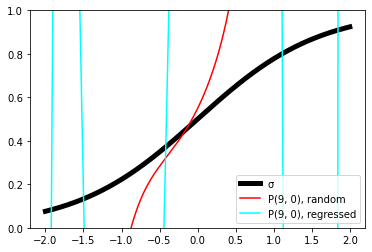

In [2]:
np.random.seed(0)

# first, we declare our w parameters randomly
# this will represent a ninth order polynomial

omega = np.random.random(10).reshape((-1, 1))

# next, redeclare our t axis to ensure we are within the radius of convergence

t = np.linspace(-2., 2., AXIS_SIZE).reshape((-1, 1))
pows = np.array(range(10))
T_9 = np.power(t, pows)
p_9 = T_9 @ omega

# plot the original function

plt.ylim((0., 1.))
plt.plot(t, np_sigmoid, color='black', linewidth=5, label='σ')
plt.plot(t, p_9, color='red', label='P(9, 0), random')

# define our loss function

def _mse(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    m = len(y_pred)
    
    mse = (1. / (2 * m)) * np.sum((y_pred - y_true) ** 2)
    
    return mse

# and its gradient

def _dmse(y_pred, y_true, t_axis):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    m = len(y_pred)
    
    diff = (y_pred - y_true).reshape((-1, 1))
    dmse = (1. / m) * t_axis.T @ diff

    return dmse

# as well as a convenient factorial function

def _factorial(n):
    f = 1
    for i in range(1, n + 1):
        f *= i

    return f

# create our descent loop

alpha = 0.001
steps = 10000
inv_fact = np.array([1. / _factorial(i) for i in range(10)]).reshape((-1, 1))
initial_cost = _mse(p_9, np_sigmoid)
for step in range(steps):
    omega -= alpha * _dmse(p_9, np_sigmoid, T_9) * inv_fact
    p_9 = T_9 @ omega
    cost = _mse(p_9, np_sigmoid)

print(f"Initial Cost: {initial_cost}, Final Cost: {cost}")

# plot our final function

plt.plot(t, p_9, color='cyan', label='P(9, 0), regressed')
plt.legend()

Looks terrible, right? Even after 10000 steps, this horrible regression doesn't even remotely resemble the true function. In the single test I had the patience to do, the regression wasn't even passable after 100 million steps (though definitely an improvement to 10000 steps). So what went wrong? This algorithm teaches us three important lessons:

1. Our step size is tiny for the larger terms, and, while it will eventually converge, it will take its time doing so. Optimizers with momentum don't struggle with this as much, so $\color{green}{\text{more advanced optimization algorithms must be used to get good results.}}$


2. Polynomials behave differently for inputs greater than one and less than one. For inputs less than one, the smaller power terms are much more influential on the value of the approximation. High order terms contribute basically nothing to the final sum, and thus having inaccurate values of $\omega$ for large terms isn't much of an issue. For inputs greater than one, the opposite is true. The polynomial sum will be dominated by the largest term or two, and therefore having erroneous coefficients will cause a massive discrepency. Therefore, while being within the DoC is necessary for convergence, $\color{green}{\text{further limiting the domain to [-1, 1] is often necessary to converge quickly}}$ (and, as we will later see, to avoid overflow errors).


3. The probability of our random, high-order polynomial resembling any useful function is, for all practical purposes, zero. Therefore, with a bit of intuition, it would be highly beneficial to $\color{green}{\text{initialize the coefficients to what we think the output space should look like.}}$

All three of these can and will be handled by a proper class definition for our Taylor polynomials, but for now let's try to apply lesson number three.

Initial Cost: 0.0007905309526608736, Final Cost: 0.0015291046222968452


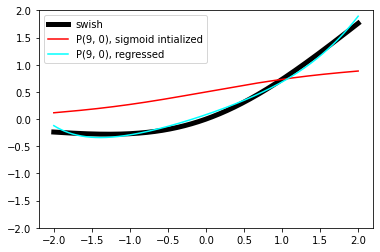

In [3]:
# to test this, we will use the popular swish function, which is a linearly scaled sigmoid

swish = t / (1. + np.exp(-t))

# first, we borrow some terms from our accurate series representation of sigmoid as our starting coefficients

c_9 = np.array(c_11[:10], dtype=np.float64) # c_9 is explicitly cast here to improve speeds
                                            # np arrays of sympy polynomial coefficients default to dtype object
p_9 = T_9 @ c_9

# plot the original functions

plt.ylim((-2., 2.))
plt.plot(t, swish, color='black', linewidth=5, label='swish')
plt.plot(t, p_9, color='red', label='P(9, 0), sigmoid intialized')

# create our same descent loop
alpha = 0.001
steps = 10000
inv_fact = np.array([1. / _factorial(i) for i in range(10)]).reshape((-1, 1))
omega = c_9
initial_cost = _mse(p_9, np_sigmoid)
for step in range(steps):
    omega -= alpha * _dmse(p_9, swish, T_9) * inv_fact
    p_9 = T_9 @ omega
    cost = _mse(p_9, swish)

print(f"Initial Cost: {initial_cost}, Final Cost: {cost}")

# plot our final function

plt.plot(t, p_9, color='cyan', label='P(9, 0), regressed')
plt.legend()

Much better than before. In the following sections, we will define an operational layer definition of a Taylor polynomial, as well as an optimizer to help it learn. Following that, we will test our layer as a means of regression, as well as its effectivness as an activation function in three different types of simple deep models.

# The TaylorActivation Layer

First things first, let's import the rest of the dependencies our classes will be needing, and we'll define a useful function as well.

In [4]:
import tensorflow as tf
from sympy import log, tanh, Expr
from tensorflow import keras
from tensorflow.python.ops import math_ops, array_ops
from keras import layers
from typing import Union

In [5]:
def _clip_by_abs(x, clip):
    x = tf.clip_by_value(x, -clip, clip)

    return x

The actual layer allows us to implement our above algorithm much more simply than before, with the below class handling all necessary calculation. The only thing the user has to specify is the order, though as we showed earlier it's smart to give the function an initial value as well. Luckily, we can do that either by specifying a sympy function or with one of three common strings: 'sigmoid', 'tanh', and 'softplus'. More will be added eventually.

As currently implemented, TaylorActivation cannot handle piecewise functions, so there is currently no true replacement for ReLU. Softplus is a continuous function that acts like ReLU in small and large limits, and thus it is included as the best available substitution. However, as we will demonstrate, softplus does not function particularly well in domains close to zero, and models that function well with ReLU will not necessarily act well with softplus.

This layer can be used in any keras.model, and its usage is easily compared to activation layers such as tf.keras.layers.ReLU. 

In [6]:
class TaylorActivation(layers.Layer):
    """
    Usage: Add a TaylorActivation layer to any keras model as you would any other layer.
           TaylorActivation layers act as self-learning activation functions with a set
           of nonlinear weights. Caution must be used with the input and output spaces of
           this layer to ensure there are no overflows. The clip_in and clip_out parameters
           have been included to prevent this, but their use should be minimized as they
           will reduce variance of propagated values.
    Args:
        order: An integer to be the degree of the polynomial to be used in the calculations
        initial: A predefined string or sympy.Expr to be used in calculating the
                 initial values of the series coefficients. Allowed string values
                 are currently 'random', 'linear', 'sigmoid', 'softplus', and 'tanh'
        symbol: A sympy.Symbol to differentiate against in the case of a user-defined
                initial function. Defaults to None
        clip_in: A float representing the maximum absolute value allowed for 
                 input values. Larger absolute values will be clipped to this.
                 Defaults to np.inf
        clip_out: A float representing the maximum absolute value allowed for 
                  output values. Larger absolute values will be clipped to this.
                  Defaults to np.inf
    """
    def __init__(self,
                 order:int,
                 initial:Union[str, Expr]='random',
                 symbol:Symbol=None,
                 clip_in:float=np.inf,
                 clip_out:float=np.inf):
        super(TaylorActivation, self).__init__()
        self.order = order
        self.initial = initial
        self.symbol = symbol
        self.clip_in = clip_in
        self.clip_out = clip_out
        self.w = None # parameter to store trainable weights once initialized

    def taylor_initializer(self):
        if self.initial == 'random':
            # initializes w randomly
            # not recommended
            coefs = tf.random_normal_initializer()(shape=[self.order + 1, 1])

            return coefs

        elif self.initial == 'linear':
            # initializes a linear term, but sets all other coefficients to zero
            # this represents a linearly scaled output
            coefs = []
            for i in range(self.order + 1):
                if i == 1:
                    term = 1
                else:
                    term = 0
                coefs.append(term)

            coefs = tf.constant(coefs, shape=[self.order + 1, 1], dtype=tf.float32)

            return coefs

        else:
            # if initial is a string, the corresponding sympy function is utilized
            # if the string is not in the approved list, a ValueError is returned
            x = Symbol('x')

            if self.initial == 'softplus':
                func = log(1. + exp(x))
            elif self.initial == 'sigmoid':
                func = 1. / (1. + exp(-x))
            elif self.initial == 'tanh':
                func = tanh(x)
            elif isinstance(self.initial, str):
                raise ValueError
            else:
                # if initial is a sympy function, it is assigned to func
                # and converted to a series
                func = self.initial
                x = self.symbol
            
            coefs = Poly(func.series(x, 0, self.order + 1).removeO()).all_coeffs()

            coefs = _order_check(np.flip(coefs), self.order)  # sympy floats are incompatible with tensorflow

            # coefficients are cast to a tensor and returned
            coefs = tf.constant(coefs, shape=[self.order + 1, 1], dtype=tf.float32)

            return coefs

    def build(self, input_shape):
        # overrides the build() method required in layer definitions
        # assigns trainable parameters
        self.w = tf.Variable(name="coefficients",
                             initial_value=self.taylor_initializer(),
                             trainable=True)

    def call(self, inputs):
        # overrides the call() method required in layer definitions
        # performs calculations and returns layer output
        taylor = None
        initial_shape = tf.shape(inputs)
        
        # inputs are clipped if a value was specified
        reshaped_input = _clip_by_abs(tf.reshape(inputs, [initial_shape[0], -1, 1]), self.clip_in)
        
        # for each term in the polynomial, the inputs are raised to the corresponding power
        for i in range(self.order + 1):
            new_term = tf.ones(shape=tf.shape(reshaped_input))
            # we use repeated instances of tf.multiply instead of a single instance of tf.pow
            # tf.pow introduces numerical instabilities in the gradient
            # whereas tf.multiply does not
            for j in range(i):
                new_term = tf.multiply(new_term, reshaped_input)
            if i == 0:
                taylor = new_term
            else:
                taylor = tf.concat([taylor, new_term], axis=2)

        flat_output = tf.reduce_sum(tf.matmul(taylor, self.w), axis=2)
        
        # outputs are clipped to avoid overflow
        flat_output = _clip_by_abs(flat_output, self.clip_out)
        output_shaped = tf.reshape(flat_output, initial_shape)


        return output_shaped
    
    def get_config(self):
        # overrides get_config() method
        config = super(TaylorActivation, self).get_config()
        config.update({
            'order': self.order,
            'initial': self.initial,
            'symbol': self.symbol,
            'safety': self.safety,
        })


Additionally, we include a custom optimizer to handle our scaled learning rates. Due to its widespread success, we have elected to implement the Adam optimizer with the amsgrad algorithm varient. This optimizer will ensure that terms with larger powers do not change too quickly, but the momentum will allow it to converge as quickly as possible.

IMPORTANT: Do not use TaylorAdam with any non-TaylorActivation layers. The scaled learning rate will cause most of the parameters to recieve little to no change. One should utilize tfa.optimizers.MultiOptimizer to ensure that each layer is properly trained.

In [7]:
class TaylorAdam(keras.optimizers.Optimizer):
    """
    Usage: An optimizer to apply scaled learning rates to learned polynomial
           weights. The amsgrad variant of the Adam algorithm is used here.
           
           IMPORTANT: Do not use TaylorAdam with any non-TaylorActivation 
           layers. The scaled learning rate will cause most of the parameters
           to recieve little to no change. One should utilize
           tfa.optimizers.MultiOptimizer to ensure that each layer is 
           properly trained.
    Args:
        learning_rate: A float to be used as the initial learning rate of the
        algorithm.
        beta_1: A float to be used as the exponential decay rate for the
        first moment estimates.
        beta_2: A float to be used as the exponential decay rate for the
        second moment estimates.
        epsilon: A small float to be used to avoid division by zero
    """
    def __init__(self,
                 learning_rate:float=0.0001,
                 beta_1:float=0.9,
                 beta_2:float=0.999,
                 epsilon:float=1e-7,
                 name:str="TaylorAdam",
                 **kwargs):
        super().__init__(name, **kwargs)
        # parameters are assigned as hyperparameters
        self._set_hyper("learning_rate", learning_rate)
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper("beta_1", beta_1)
        self._set_hyper("beta_2", beta_2)
        self.epsilon = epsilon

    def _create_slots(self, var_list):
        # For each variable, a slot is created for it
        # three consecutive loops are used to preserve ordering
        for var in var_list:
            self.add_slot(var, "m")
        for var in var_list:
            self.add_slot(var, "v")
        for var in var_list:
            self.add_slot(var, "v_hat")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        # updates the slots and performs a single optimization step
        
        # learning rate scaling tensor is declared with similarity to taylor series formula
        fact_arr = tf.constant([1. / _factorial(n) for n in range(var.shape[0])], shape=[var.shape[0], 1])
        var_dtype = var.dtype.base_dtype

        # variables are updated according to amsgrad variant of Adam
        lr_d = self._decayed_lr(var_dtype)
        local_step = math_ops.cast(self.iterations + 1, var_dtype)
        beta_1 = self._get_hyper("beta_1", var_dtype)
        beta_2 = self._get_hyper("beta_2", var_dtype)
        beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
        beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
        beta_1_power = math_ops.pow(beta_1_t, local_step)
        beta_2_power = math_ops.pow(beta_2_t, local_step)

        m = self.get_slot(var, "m")
        v = self.get_slot(var, "v")
        v_hat = self.get_slot(var, "v_hat")

        m_t = m * beta_1 + (1. - beta_1) * grad
        v_t = v * beta_2 + (1. - beta_2) * grad ** 2
        v_hat_t = math_ops.maximum(v_t, v_hat)

        lr_t = lr_d * tf.sqrt(1. - beta_2_power) / (1. - beta_1_power)

        var_t = var - lr_t * m_t * fact_arr / (tf.sqrt(v_hat_t) + self.epsilon)

        # updated variables are assigned to their slots
        m.assign(m_t)
        v.assign(v_t)
        v_hat.assign(v_hat_t)
        var.assign(var_t)

    def get_config(self):
        # overrides the get_config() optimizer method
        config = super(TaylorAdam, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'decay': self._initial_decay,
            'beta_1': self._serialize_hyperparameter('beta_1'),
            'beta_2': self._serialize_hyperparameter('beta_2'),
            'epsilon': self.epsilon,
        })

        return config

# TaylorActivation: Regression

The first, and easiest, use of our TaylorActivation layer is to perform simple regression. We will 

In [8]:
# more imports 
from keras import Sequential

Epoch 1/100
32/32 [==============================] - 1s 1ms/step - loss: 0.2773
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0457
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0148
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0135
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0125
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 8/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0103
Epoch 9/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 10/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0094
Epoch 11/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 12/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0082
Epoch 13/100
32/32 [=================

32/32 [==============================] - 0s 1ms/step - loss: 1.0387e-04
Epoch 100/100
32/32 [==============================] - 0s 1ms/step - loss: 1.0377e-04
Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1015
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0091
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 4.2173e-04
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: 3.5261e-04
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - loss: 3.2316e-04
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: 2.6323e-04
Epoch 8/100
32/32 [==============================] - 0s 1ms/step - loss: 2.3836e-04
Epoch 9/100
32/32 [==============================] - 0s 1ms/step - loss: 2.6811e-04
Epoch 10/100
32/32 [==============================] - 0s 1ms/step - loss: 2.3385e-04
Epoch 11/100


32/32 [==============================] - 0s 1ms/step - loss: 6.9433e-05
Epoch 96/100
32/32 [==============================] - 0s 1ms/step - loss: 7.7939e-05
Epoch 97/100
32/32 [==============================] - 0s 1ms/step - loss: 5.7551e-05
Epoch 98/100
32/32 [==============================] - 0s 1ms/step - loss: 7.9037e-05
Epoch 99/100
32/32 [==============================] - 0s 1ms/step - loss: 6.5239e-05
Epoch 100/100
32/32 [==============================] - 0s 1ms/step - loss: 6.7827e-05
Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 0.8131
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0450
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 8.3949e-04
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: 5.0864e-04
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - loss: 3.9116e-04
Epoch 7/10

32/32 [==============================] - 0s 1ms/step - loss: 5.8722e-05
Epoch 92/100
32/32 [==============================] - 0s 1ms/step - loss: 5.8982e-05
Epoch 93/100
32/32 [==============================] - 0s 1ms/step - loss: 6.8356e-05
Epoch 94/100
32/32 [==============================] - 0s 1ms/step - loss: 6.3273e-05
Epoch 95/100
32/32 [==============================] - 0s 1ms/step - loss: 5.9650e-05
Epoch 96/100
32/32 [==============================] - 0s 1ms/step - loss: 7.0061e-05
Epoch 97/100
32/32 [==============================] - 0s 1ms/step - loss: 6.0970e-05
Epoch 98/100
32/32 [==============================] - 0s 1ms/step - loss: 6.7903e-05
Epoch 99/100
32/32 [==============================] - 0s 1ms/step - loss: 6.3115e-05
Epoch 100/100
32/32 [==============================] - 0s 1ms/step - loss: 5.9529e-05
Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 1.0231
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0556
Ep

32/32 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 92/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 93/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 94/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 95/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 96/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 97/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 98/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 99/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 100/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0017


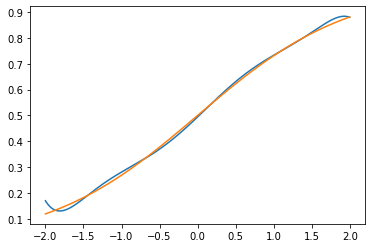

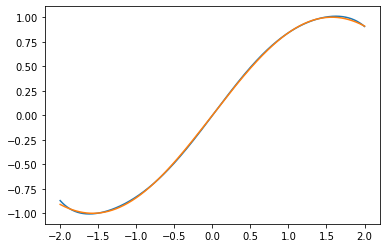

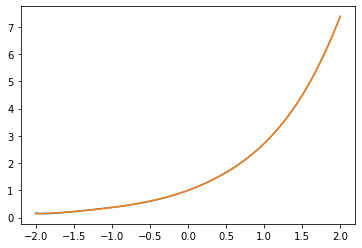

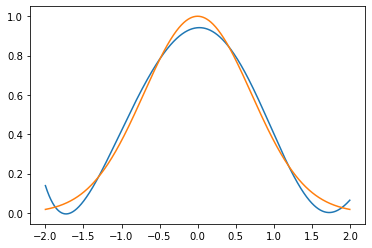

In [9]:
tf.random.set_seed(1)

# first, we declare a number of continuous functions to approximate
t = np.linspace(-2., 2., 1001)
sigmoid = 1. / (1. + np.exp(-t))
sin = np.sin(t)
exponential = np.exp(t)
gaussian = np.exp(-1. * (t ** 2))

functions = [sigmoid, sin, exponential, gaussian]

# second, declare our model
# note here that we are actually using random initialization
# this is because within a keras model and with a proper optimizer
# our layer is actually quite robust
regression_model = Sequential([TaylorActivation(7)])
regression_model.compile(optimizer=TaylorAdam(learning_rate=0.1),
                         loss='mse')

for i, f in enumerate(functions):
    plt.figure(i)
    regression_model.fit(t, f, epochs=100)
    y_pred = regression_model(t)
    plt.plot(t, y_pred)
    plt.plot(t, f)

Some functions converge more quickly than others. For example, here's what the gaussian looks like after another 300 epochs:

Epoch 1/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 2/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 3/300
32/32 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 4/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 5/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 6/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 7/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 8/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 9/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 10/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 11/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 12/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 13/300
32/32 [=================

32/32 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 103/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 104/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 105/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 106/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 107/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 108/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 109/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 110/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 111/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 112/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 113/300
32/32 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 114/300
32/32 [=========

32/32 [==============================] - 0s 1ms/step - loss: 7.5641e-04
Epoch 199/300
32/32 [==============================] - 0s 1ms/step - loss: 7.1576e-04
Epoch 200/300
32/32 [==============================] - 0s 1ms/step - loss: 7.7219e-04
Epoch 201/300
32/32 [==============================] - 0s 1ms/step - loss: 7.3525e-04
Epoch 202/300
32/32 [==============================] - 0s 1ms/step - loss: 7.1749e-04
Epoch 203/300
32/32 [==============================] - 0s 1ms/step - loss: 7.1041e-04
Epoch 204/300
32/32 [==============================] - 0s 1ms/step - loss: 7.1319e-04
Epoch 205/300
32/32 [==============================] - 0s 1ms/step - loss: 7.0796e-04
Epoch 206/300
32/32 [==============================] - 0s 1ms/step - loss: 7.2253e-04
Epoch 207/300
32/32 [==============================] - 0s 1ms/step - loss: 7.1055e-04
Epoch 208/300
32/32 [==============================] - 0s 1ms/step - loss: 7.0631e-04
Epoch 209/300
32/32 [==============================] - 0s 1ms/step -

32/32 [==============================] - 0s 1ms/step - loss: 5.1335e-04
Epoch 294/300
32/32 [==============================] - 0s 1ms/step - loss: 5.3564e-04
Epoch 295/300
32/32 [==============================] - 0s 1ms/step - loss: 5.1790e-04
Epoch 296/300
32/32 [==============================] - 0s 1ms/step - loss: 5.0276e-04
Epoch 297/300
32/32 [==============================] - 0s 1ms/step - loss: 5.0082e-04
Epoch 298/300
32/32 [==============================] - 0s 1ms/step - loss: 5.1031e-04
Epoch 299/300
32/32 [==============================] - 0s 1ms/step - loss: 4.8502e-04
Epoch 300/300
32/32 [==============================] - 0s 1ms/step - loss: 5.0003e-04


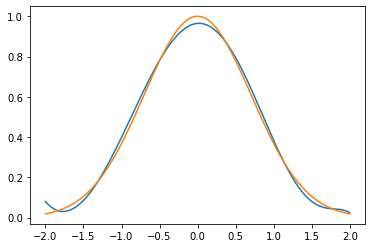

In [10]:
    regression_model.fit(t, gaussian, epochs=300)
    y_pred = regression_model(t)
    plt.plot(t, y_pred)
    plt.plot(t, f)

A considerable improvement in the tails of the bell curve. But for regression, this is slow, largely due to the custom optimizer in use. Can we use other optimizers and still get a good fit? In the case of simple regression, yes. Here's an example using the standard Adam optimizer. It is actually quite a bit faster at converging when the coefficients are extremely inaccurate, however for fine tuning the TaylorAdam optimizer should always be used.

In [11]:
tf.random.set_seed(1)

regression_model = Sequential([TaylorActivation(7)])
regression_model.compile(optimizer='adam',
                         loss='mse')

regression_model.fit(t, sigmoid, epochs=100)

Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6017
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 0.2164
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1792
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1514
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1263
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1045
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0860
Epoch 8/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0704
Epoch 9/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0578
Epoch 10/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0476
Epoch 11/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0396
Epoch 12/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0332
Epoch 13/100
32/32 [=================

32/32 [==============================] - 0s 1ms/step - loss: 1.6233e-04
Epoch 100/100
32/32 [==============================] - 0s 1ms/step - loss: 1.6142e-04


# TaylorActivation: Simple Deep Models

Regression is nothing special, and is largely a solved problem. How does the layer perform in deep models? Here, we will explore the benefits and limits of using the TaylorActivation layer in three different types of models: a simple fully-connected model, a small convolutional neural network, and a small recurrent neural network. We will also test how well this layer works when used early in the model compared to later.

First, let's select our datasets. For our first model, we will test how good at predicting a real number output our model is when a layer of polynomial regression is added compared to a linear output layer. We will test this using the [forest_fires dataset](https://www.tensorflow.org/datasets/catalog/forest_fires).

For our second model, we will tackle image classification. To keep things simple, a dataset with only two classes will be used. This will also give us an opportunity to compare staring out our layer with both linear and sigmoid initializers. The [cats_vs_dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) will be implemented.

For our third model, we will test how good our layer performs compared to traditional models when predicting recursive output. We will utilize the [cherry_blossoms](https://www.tensorflow.org/datasets/catalog/cherry_blossoms) dataset. 

In [12]:
import tempfile
import tensorflow_datasets as tfds

# make a temporary directory to store our datasets
temp_dir = "tmp"
print(temp_dir)

forest_fires_ds = tfds.load('forest_fires', split='train', data_dir=temp_dir)

# the image dataset cannot be loaded into memory
# therefore, we create splits here
cats_vs_dogs_ds_train, cats_vs_dogs_ds_val = tfds.load('cats_vs_dogs', split=['train[:75%]', 'train[75%:]'], data_dir=temp_dir, as_supervised=True)

/home/awalsh/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tmp


Next, we'll inspect and format our datasets. Let's start with forest_fires_ds:

In [13]:
ff_df = tfds.as_dataframe(forest_fires_ds)

print(ff_df.info())

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   area            517 non-null    float32
 1   features/DC     517 non-null    float32
 2   features/DMC    517 non-null    float32
 3   features/FFMC   517 non-null    float32
 4   features/ISI    517 non-null    float32
 5   features/RH     517 non-null    float32
 6   features/X      517 non-null    int8   
 7   features/Y      517 non-null    int8   
 8   features/day    517 non-null    int64  
 9   features/month  517 non-null    int64  
 10  features/rain   517 non-null    float32
 11  features/temp   517 non-null    float32
 12  features/wind   517 non-null    float32
dtypes: float32(9), int64(2), int8(2)
memory usage: 27.4 KB
None


All data types are already numerical, and there are no null values present. Therefore, we're good to proceed with a few transformations.

In [14]:
# first, as noted by the dataset description, the area data is heavily skewed towards zero
# as such, a logarithmic transformation is suitable

ff_df['area'] = np.log(ff_df['area'] + 1.)

# followed by standardization

ff_df = (ff_df - ff_df.mean()) / ff_df.std()

# and finally split it into training and validation sets

train_frac = 0.75
ff_entries = len(ff_df)
split_index = int(train_frac * ff_entries)

ff_train = ff_df.iloc[:split_index].to_numpy()
ff_val = ff_df.iloc[split_index:].to_numpy()

# and split further into features and labels

ff_train_x, ff_train_y = ff_train[:, 1:], ff_train[:, 0]
ff_val_x, ff_val_y = ff_val[:, 1:], ff_val[:, 0]

Next, we will define a function to generate a traditional dense network.

In [15]:
def make_traditional_dense():
    traditional_dense = Sequential([layers.Dense(12),
                                    layers.Activation('softplus'),
                                    layers.Dense(128),
                                    layers.ReLU(),
                                    layers.Dense(128),
                                    layers.ReLU(),
                                    layers.Dense(128),
                                    layers.ReLU(),
                                    layers.Dense(1),
                                    layers.Activation('linear')])

    traditional_dense.compile(loss='mse', optimizer='adam', metrics='mae')

    return traditional_dense


Now we do the same for our image dataset. CNN models do not always require activation functions for the final output space, but in the case of binary data sigmoid outputs often improve performance. We'll test both.

In [16]:
# create a basic datapipe

IMG_SIZE = 64 # side length to resize images to

def cd_preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE]) / 255.

    return image, label

cd_ds_train = cats_vs_dogs_ds_train.map(cd_preprocess).batch(32)
cd_ds_val = cats_vs_dogs_ds_val.map(cd_preprocess).batch(32)


And once more for our RNN

This dataset will require a bit more work, as their are quite a few missing values in the day-of-year ('doy') column. Additionally, the temperature columns are missing values as well. Strangely, almost all of the temperature data points that are missing are the most recent years. Since there's no fixing almost 100 consecutive years of faulty data, we will drop those rows. The only two other years missing data occur *very* early on, so we will simply drop all values earlier than those points to make windowing easier for ourselves. What we are left with is 1106 years of consecutive temperature data.

The doy column is a bit more problematic, as missing dates are spread out randomly. Therefore, the cannot be dropped without slicing up our dataset. Furthermore, they have a standard deviation corresponding to almost a week, and therefore dates are spread out plus and minus one month from the mean. Thus, substituting the average isn't a great idea, either. Therefore, we'll make use of sklearn.impute.KNNImputer. Because the number of possible doys is quite high, and the dataset size is relatively small making large values of $k$ inviable, we'll weight the neighbors with the inverse distance.

Now, we'll standardize our cleaned dataset and define a basic RNN.

## Limitations and Pitfalls

You may have noticed that all four of the models share a couple of features. The first is that each model ends in a generalized Activation layer, three of which are linear. In the linear cases, the layer does nothing and is only there for comparability with our upcoming Taylor models. The other shared feature is that the first activation function in each model is a *softplus* function, defined as 

$$
\text{softplus}(x) = \log(1 + e^{x}).
$$

The reason softplus is implemented in our test models instead of another instance of ReLU is that TaylorActivation layers can be a nearly perfect substitute for softplus functions, but ReLU cannot yet be accurately approximated. Softplus is considered to be a continuous approximation of ReLU, at least in the limit of large modulus of the input. Our models must be as similar as possible, therefore we test using at least one softplus function per model. This leads us to our first limitation:

* All activation functions that TaylorActivation is capable of approximating must be continuous and differentiable within the input domain, as well as needing a convergent series.

This isn't too bad, but until piecewise domains are added to the class capabilities no "hard" activation functions are suitable for replacement. Our second limitation deals with training. Namely, the ability to converge during training. Let's examine our backpropagation formula,

$$
\omega_{n} \rightarrow \omega_{n} - \alpha_{\omega}\frac{\partial J}{\partial \omega_n},
$$

with more focus put onto the actual value of the derivative of our cost function. In the above formula, $\alpha_{\omega}$ represents the learning rate associated with that variable, be it the usual constant $\alpha$ or our $\alpha/n!$ for polynomial weights. When fully expanded using the chain rule, we see

$$
\omega_{n} \rightarrow \omega_{n} - \alpha_{\omega} \frac{\partial J}{\partial f_n}\frac{\partial f_n}{\partial z_n}\frac{\partial z_n}{\partial \omega_{n}} ,
$$

where $f_{n}$ is the activation function of the layer $\omega_n$ is a weight in, and $z_n$ is the output of a layer before it is fed to $f_n$. This formula, of course, becomes grossly longer as you go earlier into a model and fully expand each of the three differentials involved. The most important of these terms is the middle, $\partial f_n / \partial z_n$. In the case of the sigmoid, this expression is nice.

$$
\frac{\partial \sigma}{\partial z} = \sigma(1 - \sigma).
$$

The value of the function only changes with changing $z$. More explicitly, the optimization landscape has only one degree of freedom introduced by that particular activation function. This is also the case in all other static activation functions. In the case of a *trainable* polynomial of degree $m$, the gradient looks more like

$$
\nabla P(k, 0) = \sum_{k=0}^{m-1} kp_{k}x^{k-1},
$$

where $p_k$ are our nonlinear weights. This means that during any given optimization step, $k$ weights that *will be updated during the step* are used to calculate the change in $\omega_n$. This can cause three problems. Firstly, in addition to the z-axis degree of freedom, the use of a Taylor layer of order $k$ will introduce $k$ degrees of freedom to our optimization process, slowing things down and making it more likely our descent gets stuck in a local minimum. Secondly, because $p_k$ is being updated along with $w_n$, the changes may offset each other at the end of an optimization step. Thirdly, because these parameters are nonlinear and a part of an activation function, $p_k$ will show up in *every gradient expression* for parameters that show up earlier than the polynomial. This means that they can have a massive impact on a model's performance compared to other parameters, and faulty values will be very impactful. To summarize,

* TaylorActivation layers optimize more slowly than models with traditional activation functions, and they are more likely to get stuck in false minima.

Now, for our pitfall. TaylorActivation layers are *incredibly* unstable numerically. NaNs will be a dime a dozen during training. This instability can come from a number of places, but they all can be summed up with a single property of polynomials: these functions are unbounded. They will behave well within the radius of convergence, but depending on the degree and the dataset, one has to be very careful about the input spaced used. The causes of instability that I have observed are:

1. The output space of the polynomial does not match the appropriate input space of the loss function. For example, cross entropy losses require that the input be strictly between zero and one, non inclusive. While the TaylorActivation layer *should* behave nicely in this domain, there is nothing stopping it from suddenly changing to output slightly smaller or larger values. Additionally, the input may be outside of the disk of convergence, and therefore can have an unpredictable output. To avoid this, numerically stable loss functions should be used (i.e. cross entropy from_logits), or the clip_out argument should be used.


2. Polynomials are unbounded, which is especially problematic with high degree layers. For example, consider an order 31 polynomial, and consider an input of $z=20$. That means the largest single term calculated before addition is $20^{31}$, which, as far as tensorflow is concerned, is inifinite. Float overflows are very common, and double digit outputs that many functions would handle just fine will cause your model to implode if fed to a Taylor layer. To avoid this, two precautions should be used. First, large degrees are often overkill and should be avoided if possible. Second, the function input should be controlled by whatever means necessary to ensure values are within [-1, 1]. The clip_in argument is one such option, but we will discuss more later.


3. The clip_in and clip_out arguments will reduce the values of internal tensors abruptly. This means that all inputs with a value larger than clip_in will be mapped to the same point. The same is true for clip_out and the outputs. While this won't cause NaNs to be calculated, this can highly reduce the variance of the values propagated through the model. To avoid this, only use these arguments as a last resort.


4. The parity of the polynomial chosen in comparison to the function it mimics matters. For example, $\tanh(x)$ is an odd function. If we were to fit it using an even polynomial, degree 8, for instance, then the behavior of our approximation for more extreme input values may be undesirable (note: the $\tanh$ series contains only odd powers, but the even parameters can be trained to be non-zero). More specifically, odd polynomials diverge towards $\pm\infty$, whereas even polynomials tend to one of poitive *or* negative inifinity. Depending on the task, one of these end behaviors will play more nicely with the model at large. While this also won't cause NaNs, it may lead to faulty predictions as negative inputs get mapped to positive values.


5. **FIXED** The usage of tf.pow in earlier versions of the class definition caused an exploding gradient. Truth be told, I'm not sure why this was, but it resulted in some 90% of my training attempts during testing leading to NaNs. Changing the call() function to calculate using tf.multiply repeatedly made the process much smoother. So, if you're thinking of changing the class definition to better fit your use case, don't change that.

## Methods

Our tests will be quite simple. For each model, we will declare a metric to measure its efficacy. We will then instantiate and train each model three hundred times, keeping track of the best measure of the validation metric for each run. We will then compare the average value of said metric for each mode to determine which model is superior.

Note, though, that the Taylor models have a small number of parameters more than their traditional counterparts. As such, one might be concerned that they are more powerful due to this alone, and not because of the actual function of the extra parameters. As such, we will be scaling the metrics to the size of the model. The two metrics we will be using are,

1. For the classification models, accuracy divided by total trainable parameter count


2. For the dense models, we will use the inverse mean absolute error divided by total trainable parameter count

## Tests: Final Activation Layer Substitution

In this section, we will test how Taylor models compare to traditional models when only the activation function corresponding to the final output space is substituted for a trainable nonlinear layer. First, we will define a few testing parameters. The thresholds below are notably low numbers which we will ensure a model is better than before counting it in the tests, as sometimes our model is doomed to fail right from random initialization, especially in the case of the classifiers. We will also monitor how often each version of each model fails to converge.

In [17]:
# we'll be needing this
from tensorflow_addons.optimizers import MultiOptimizer

# as well as a few testing parameters

EPOCHS = 30
LEARNING_RATE = 1e-5

# our numeric models will be considered converged if it predicts within 0.79 deviations on average
# this is the (truncated) threshold for guessing

DENSE_CONVERGENCE_THRESHOLD = 0.79 # maximum allowed metrics

# our classifier model will be considered converged if it predicts accurately 55% of the time 

CNN_CONVERGENCE_THRESHOLD = 0.55 # minumum allowed metric

# and the number of successful tests we want for proper analysis
NUM_TESTS = 20

In [18]:
tf.random.set_seed(0)

def make_traditional_dense():
    traditional_dense = Sequential([layers.Input(shape=(12,)),
                                    layers.Dense(128),
                                    layers.Activation('softplus'),
                                    layers.Dense(128),
                                    layers.ReLU(),
                                    layers.Dense(128),
                                    layers.ReLU(),
                                    layers.Dense(128),
                                    layers.ReLU(),
                                    layers.Dense(1),
                                    layers.Activation('linear')])

    traditional_dense.compile(loss='mse',
                              optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                              metrics='mae')

    return traditional_dense

traditional_dense_tests = 0
testing = True
traditional_dense_min_mae = np.array([])
while testing:
    traditional_dense = make_traditional_dense()

    traditional_dense_history = traditional_dense.fit(ff_train_x,
                                                      ff_train_y,
                                                      validation_data=[ff_val_x, ff_val_y],
                                                      epochs=EPOCHS,
                                                      verbose=0,
                                                      shuffle=True)
    
    traditional_dense_mae = traditional_dense_history.history.get('mae')
    traditional_dense_val_mae = traditional_dense_history.history.get('val_mae')
    
    min_mae = min(traditional_dense_mae)
    if min_mae <= DENSE_CONVERGENCE_THRESHOLD:
        traditional_dense_min_mae = np.append(traditional_dense_min_mae, min(traditional_dense_val_mae))
    
    if len(traditional_dense_min_mae) == NUM_TESTS:
        testing = False
    
    traditional_dense_tests += 1
    print(f"Converged tests: {len(traditional_dense_min_mae)}/{NUM_TESTS}, Total tests: {traditional_dense_tests}")

Converged tests: 1/20, Total tests: 1
Converged tests: 2/20, Total tests: 2
Converged tests: 3/20, Total tests: 3
Converged tests: 3/20, Total tests: 4
Converged tests: 4/20, Total tests: 5
Converged tests: 5/20, Total tests: 6
Converged tests: 6/20, Total tests: 7
Converged tests: 7/20, Total tests: 8
Converged tests: 8/20, Total tests: 9
Converged tests: 8/20, Total tests: 10
Converged tests: 8/20, Total tests: 11
Converged tests: 9/20, Total tests: 12
Converged tests: 10/20, Total tests: 13
Converged tests: 11/20, Total tests: 14
Converged tests: 12/20, Total tests: 15
Converged tests: 13/20, Total tests: 16
Converged tests: 13/20, Total tests: 17
Converged tests: 14/20, Total tests: 18
Converged tests: 15/20, Total tests: 19
Converged tests: 15/20, Total tests: 20
Converged tests: 16/20, Total tests: 21
Converged tests: 17/20, Total tests: 22
Converged tests: 17/20, Total tests: 23
Converged tests: 18/20, Total tests: 24
Converged tests: 18/20, Total tests: 25
Converged tests: 19/2

In [19]:
tf.random.set_seed(0)

def make_taylor_dense_final():
    taylor_dense_final = Sequential([layers.Input(shape=(12,)),
                                     layers.Dense(128),
                                     layers.Activation('relu'),
                                     layers.Dense(128),
                                     layers.ReLU(),
                                     layers.Dense(128),
                                     layers.ReLU(),
                                     layers.Dense(128),
                                     layers.ReLU(),
                                     layers.Dense(1),
                                     TaylorActivation(order=9, initial='linear')])
    
    traditional_layers = taylor_dense_final.layers[:-1]
    taylor_layers = [taylor_dense_final.layers[-1]]
    
    # we don't want to apply a normal optimizer to our custom layer
    # and we don't want to apply our custom optimizer to normal layers
    # MultiOptimizer applies different optimizers to different layers
    taylor_optimizer = MultiOptimizer([(keras.optimizers.Adam(learning_rate=LEARNING_RATE), traditional_layers),
                                       (TaylorAdam(learning_rate=LEARNING_RATE), taylor_layers)])

    taylor_dense_final.compile(loss='mse', optimizer=taylor_optimizer, metrics='mae')
    
    return taylor_dense_final

taylor_dense_final_tests = 0
testing = True
taylor_dense_final_min_mae = np.array([])
while testing:
    taylor_dense_final = make_taylor_dense_final()

    taylor_dense_final_history = taylor_dense_final.fit(ff_train_x,
                                                        ff_train_y,
                                                        validation_data=[ff_val_x, ff_val_y],
                                                        epochs=EPOCHS,
                                                        verbose=0,
                                                        shuffle=True)
    
    taylor_dense_final_mae = taylor_dense_final_history.history.get('mae')
    taylor_dense_final_val_mae = taylor_dense_final_history.history.get('val_mae')
    
    min_mae = min(taylor_dense_final_mae)
    if min_mae <= DENSE_CONVERGENCE_THRESHOLD:
        taylor_dense_final_min_mae = np.append(taylor_dense_final_min_mae, min(taylor_dense_final_val_mae))
    
    if len(taylor_dense_final_min_mae) == NUM_TESTS:
        testing = False
    
    taylor_dense_final_tests += 1
    print(f"Converged tests: {len(taylor_dense_final_min_mae)}/{NUM_TESTS}, Total tests: {taylor_dense_final_tests}")

Converged tests: 1/20, Total tests: 1
Converged tests: 2/20, Total tests: 2
Converged tests: 2/20, Total tests: 3
Converged tests: 3/20, Total tests: 4
Converged tests: 4/20, Total tests: 5
Converged tests: 5/20, Total tests: 6
Converged tests: 6/20, Total tests: 7
Converged tests: 7/20, Total tests: 8
Converged tests: 8/20, Total tests: 9
Converged tests: 9/20, Total tests: 10
Converged tests: 9/20, Total tests: 11
Converged tests: 10/20, Total tests: 12
Converged tests: 10/20, Total tests: 13
Converged tests: 11/20, Total tests: 14
Converged tests: 11/20, Total tests: 15
Converged tests: 12/20, Total tests: 16
Converged tests: 12/20, Total tests: 17
Converged tests: 13/20, Total tests: 18
Converged tests: 14/20, Total tests: 19
Converged tests: 15/20, Total tests: 20
Converged tests: 16/20, Total tests: 21
Converged tests: 17/20, Total tests: 22
Converged tests: 18/20, Total tests: 23
Converged tests: 18/20, Total tests: 24
Converged tests: 18/20, Total tests: 25
Converged tests: 19/

Traditional Dense Mean IMAE:  5.350e-01, Taylor Dense Final Mean IMAE:  5.301e-01
Traditional Dense IMAE Variance:  3.269e-05, Taylor Dense Final IMAE Variance:  5.301e-01
Traditional Dense Convergence Rate:  74.074%, Taylor Dense Final Convergence Rate:  71.429%


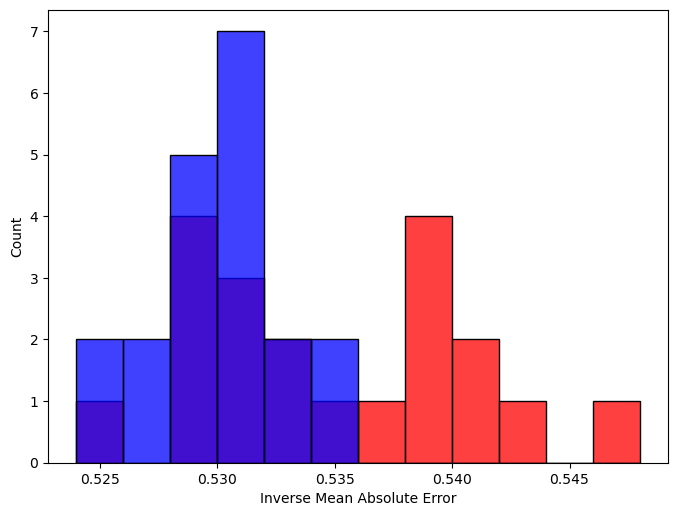

In [20]:
import seaborn as sns
from keras.utils.layer_utils import count_params
from scipy.stats import ks_2samp

# a nice function to define bins with a standard width
def make_bin_edges(bin_width, data1, data2):
    spread_min = min(min(data1), min(data2))
    spread_max = max(max(data1), max(data2))
        
    min_bin = bin_width * int(spread_min / bin_width)
    max_bin = bin_width * (int(spread_max / bin_width) + 1)
    
    n_bins = int((max_bin - min_bin) / bin_width) + 1
    
    return np.linspace(min_bin, max_bin, n_bins)
    
traditional_dense_parameter_count = sum(count_params(layer) for layer in traditional_dense.trainable_weights)
taylor_dense_final_parameter_count = sum(count_params(layer) for layer in taylor_dense_final.trainable_weights)

# read: inverse mean absolute error
traditional_dense_imae = 1. / (traditional_dense_min_mae + 1.)
taylor_dense_final_imae_scaled = (1. / (taylor_dense_final_min_mae + 1.)) * \
                                 (traditional_dense_parameter_count / taylor_dense_final_parameter_count)

traditional_dense_mean_imae = np.mean(traditional_dense_imae)
taylor_dense_final_mean_imae = np.mean(taylor_dense_final_imae_scaled)

traditional_dense_var_imae = np.var(traditional_dense_imae)
taylor_dense_final_var_imae = np.var(taylor_dense_final_imae_scaled)

dense_final_ks_distance = ks_2samp(traditional_dense_imae, taylor_dense_final_imae_scaled)

traditional_dense_convergence_percent = 100 * (NUM_TESTS / traditional_dense_tests)
taylor_dense_final_convergence_percent = 100 * (NUM_TESTS / taylor_dense_final_tests)

bins = make_bin_edges(0.002, traditional_dense_imae, taylor_dense_final_imae_scaled)

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

sns.histplot(traditional_dense_imae, color='red', bins=bins)
sns.histplot(taylor_dense_final_imae_scaled, color='blue', bins=bins)
plt.xlabel("Inverse Mean Absolute Error")
plt.savefig("test_images/taylor_dense_final.png")

print(f"Traditional Dense Mean IMAE: {traditional_dense_mean_imae: .3e}, Taylor Dense Final Mean IMAE: {taylor_dense_final_mean_imae: .3e}")
print(f"Traditional Dense IMAE Variance: {traditional_dense_var_imae: .3e}, Taylor Dense Final IMAE Variance: {taylor_dense_final_mean_imae: .3e}")
print(f"Traditional Dense Convergence Rate: {traditional_dense_convergence_percent: .3f}%, Taylor Dense Final Convergence Rate: {taylor_dense_final_convergence_percent: .3f}%")

The Taylor version of this model is worse in every measurable way, but that's about what we should have expected. We've appended a polynomial regression on top of our dense model, and it is subject to the same issue that all polynomial regression is: overfitting. As such, when predicting numerical values, TaylorActivation is not an especially great choice.

Next, the classification models.

In [ ]:
tf.random.set_seed(0)

def make_traditional_cnn():
    traditional_cnn = Sequential([layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
                                  layers.Conv2D(16, (3, 3)),
                                  layers.Activation('softplus'),
                                  layers.MaxPool2D((2, 2)),
                                  layers.Conv2D(32, (3, 3), activation='relu'),
                                  layers.MaxPool2D((2, 2)),
                                  layers.Conv2D(32, (3, 3), activation='relu'),
                                  layers.MaxPool2D((2, 2)),
                                  layers.Conv2D(64, (3, 3), activation='relu'),
                                  layers.MaxPool2D((2, 2)),
                                  layers.Flatten(),
                                  layers.Dense(256, activation='relu'),
                                  layers.Dense(1),
                                  layers.Activation('sigmoid')])
    
    traditional_cnn.compile(loss='bce',
                            optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                            metrics='accuracy')
    
    return traditional_cnn

traditional_cnn_tests = 0
testing = True
traditional_cnn_max_acc = np.array([])
while testing:
    traditional_cnn = make_traditional_cnn()

    traditional_cnn_history = traditional_cnn.fit(cd_ds_train,
                                                  validation_data=cd_ds_val,
                                                  epochs=EPOCHS,
                                                  verbose=1,
                                                  shuffle=True)
    
    traditional_cnn_acc = traditional_cnn_history.history.get("val_accuracy")
    
    max_acc = max(traditional_cnn_acc)
    if max_acc >= CNN_CONVERGENCE_THRESHOLD:
        traditional_cnn_max_acc = np.append(traditional_cnn_max_acc, max_acc)
    
    if len(traditional_cnn_max_acc) == NUM_TESTS:
        testing = False
    
    traditional_cnn_tests += 1
    
    print(f"Converged tests: {len(traditional_cnn_max_acc)}/{NUM_TESTS}, Total tests: {traditional_cnn_tests}")

Epoch 1/30
546/546 [==============================] - 29s 52ms/step - loss: 0.6928 - accuracy: 0.5124 - val_loss: 0.6925 - val_accuracy: 0.5014
Epoch 2/30
546/546 [==============================] - 28s 52ms/step - loss: 0.6920 - accuracy: 0.5295 - val_loss: 0.6918 - val_accuracy: 0.5253
Epoch 3/30
546/546 [==============================] - 28s 52ms/step - loss: 0.6911 - accuracy: 0.5425 - val_loss: 0.6908 - val_accuracy: 0.5327
Epoch 4/30
546/546 [==============================] - 28s 52ms/step - loss: 0.6898 - accuracy: 0.5551 - val_loss: 0.6891 - val_accuracy: 0.5545
Epoch 5/30
546/546 [==============================] - 28s 52ms/step - loss: 0.6874 - accuracy: 0.5678 - val_loss: 0.6860 - val_accuracy: 0.5755
Epoch 6/30
546/546 [==============================] - 29s 52ms/step - loss: 0.6835 - accuracy: 0.5764 - val_loss: 0.6817 - val_accuracy: 0.5875
Epoch 7/30
546/546 [==============================] - 28s 52ms/step - loss: 0.6789 - accuracy: 0.5841 - val_loss: 0.6772 - val_accuracy:

In [ ]:
tf.random.set_seed(0)

def make_taylor_cnn_final():
    taylor_cnn_final = Sequential([layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
                                   layers.Conv2D(16, (3, 3)),
                                   layers.Activation('softplus'),
                                   layers.Conv2D(32, (3, 3), activation='relu'),
                                   layers.MaxPool2D((2, 2)),
                                   layers.MaxPool2D((2, 2)),
                                   layers.Conv2D(32, (3, 3), activation='relu'),
                                   layers.MaxPool2D((2, 2)),
                                   layers.Conv2D(64, (3, 3), activation='relu'),
                                   layers.MaxPool2D((2, 2)),
                                   layers.Flatten(),
                                   layers.Dense(256, activation='relu'),
                                   layers.Dense(1),
                                   TaylorActivation(order=9, initial='sigmoid')])
        
    traditional_layers = taylor_cnn_final.layers[:-1]
    taylor_layers = [taylor_cnn_final.layers[-1]]
    
    taylor_optimizer = MultiOptimizer([(keras.optimizers.Adam(learning_rate=LEARNING_RATE), traditional_layers),
                                       (TaylorAdam(learning_rate=LEARNING_RATE), taylor_layers)])
    
    taylor_cnn_final.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=taylor_optimizer, metrics='accuracy')

    
    return taylor_cnn_final

taylor_cnn_final_tests = 0
testing = True
taylor_cnn_final_max_acc = np.array([])
while testing:
    taylor_cnn_final = make_taylor_cnn_final()

    taylor_cnn_final_history = taylor_cnn_final.fit(cd_ds_train,
                                                    validation_data=cd_ds_val,
                                                    epochs=EPOCHS,
                                                    verbose=0,
                                                    shuffle=True)

    taylor_cnn_final_acc = taylor_cnn_final_history.history.get("val_accuracy")
    
    max_acc = max(taylor_cnn_final_acc)
    if max_acc >= CNN_CONVERGENCE_THRESHOLD:
        taylor_cnn_final_max_acc = np.append(taylor_cnn_final_max_acc, max_acc)
    
    if len(taylor_cnn_final_max_acc) == NUM_TESTS:
        testing = False
    
    taylor_cnn_final_tests += 1

    print(f"Converged tests: {len(taylor_cnn_final_max_acc)}/{NUM_TESTS}, Total tests: {taylor_cnn_final_tests}")

In [ ]:
traditional_cnn_parameter_count = sum(count_params(layer) for layer in traditional_cnn.trainable_weights)
taylor_cnn_final_parameter_count = sum(count_params(layer) for layer in taylor_cnn_final.trainable_weights)

taylor_cnn_final_max_acc_scaled = taylor_cnn_final_max_acc * \
                                  (traditional_cnn_parameter_count / taylor_cnn_final_parameter_count)

traditional_cnn_mean_acc = np.mean(traditional_cnn_max_acc)
taylor_cnn_final_mean_acc = np.mean(taylor_cnn_final_max_acc_scaled)

traditional_cnn_var_acc = np.var(traditional_cnn_max_acc)
taylor_cnn_final_var_acc = np.var(taylor_cnn_final_max_acc_scaled)

dense_final_ks_distance = ks_2samp(traditional_cnn_max_acc, taylor_cnn_final_max_acc_scaled)

traditional_dense_convergence_percent = 100 * (NUM_TESTS / traditional_cnn_tests)
taylor_dense_final_convergence_percent = 100 * (NUM_TESTS / taylor_cnn_final_tests)

bins = make_bin_edges(0.002, traditional_cnn_max_acc, taylor_cnn_final_max_acc_scaled)

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

sns.histplot(traditional_cnn_max_acc, color='red')
sns.histplot(taylor_cnn_final_max_acc_scaled, color='blue')
plt.xlabel("Accuracy")
plt.savefig("test_images/taylor_cnn_final.png")

## Tests: First Activation Layer Substitution

In this section, we will perform the same tests as above, only this time we will replace the earliest activation function in the model. Because early activation functions have a larger impact on performance, and they are not as easily subject to polynomial overfitting as a one-dimensional output space, we should expect different results here, especially for the dense model.

In [ ]:
tf.random.set_seed(0)

def make_taylor_dense_first():
    taylor_dense_first = Sequential([layers.Input(shape=(12,)),
                                     layers.Dense(128),
                                     TaylorActivation(order=19, initial='softplus'),
                                     layers.Dense(128),
                                     layers.ReLU(),
                                     layers.Dense(128),
                                     layers.ReLU(),
                                     layers.Dense(128),
                                     layers.ReLU(),
                                     layers.Dense(1),
                                     layers.Activation('linear')])

    traditional_layers = [taylor_dense_first.layers[0]] + taylor_dense_first.layers[2: -1]
    taylor_layers = [taylor_dense_first.layers[1]]

    taylor_optimizer = MultiOptimizer([(keras.optimizers.Adam(learning_rate=LEARNING_RATE), traditional_layers),
                                       (TaylorAdam(learning_rate=LEARNING_RATE), taylor_layers)])

    taylor_dense_first.compile(loss='mse', optimizer=taylor_optimizer, metrics='mae')

    return taylor_dense_first


taylor_dense_first_tests = 0
testing = True
taylor_dense_first_min_mae = np.array([])
while testing:
    taylor_dense_first = make_taylor_dense_first()

    taylor_dense_first_history = taylor_dense_first.fit(ff_train_x,
                                                        ff_train_y,
                                                        validation_data=[ff_val_x, ff_val_y],
                                                        epochs=EPOCHS,
                                                        verbose=1,
                                                        shuffle=True)

    taylor_dense_first_mae = taylor_dense_first_history.history.get('mae')
    taylor_dense_first_val_mae = taylor_dense_first_history.history.get('val_mae')

    min_mae = min(taylor_dense_first_mae)
    if min_mae <= DENSE_CONVERGENCE_THRESHOLD:
        taylor_dense_first_min_mae = np.append(taylor_dense_first_min_mae, min(taylor_dense_first_val_mae))

    if len(taylor_dense_first_min_mae) == NUM_TESTS:
        testing = False

    taylor_dense_first_tests += 1
    print(f"Converged tests: {len(taylor_dense_first_min_mae)}/{NUM_TESTS}, Total tests: {taylor_dense_first_tests}")

In [ ]:
taylor_dense_first_parameter_count = sum(count_params(layer) for layer in taylor_dense_first.trainable_weights)

taylor_dense_first_imae_sclaed = (1. / (taylor_dense_final_min_mae + 1.)) * \
                                 (traditional_dense_parameter_count / taylor_dense_first_parameter_count)

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

sns.histplot(traditional_dense_imaepp, color='red')
sns.histplot(taylor_dense_final_imaepp, color='blue')
plt.xlabel("Inverse Mean Absolute Error")
plt.savefig("test_images/taylor_dense_final.png")

In [ ]:
tf.random.set_seed(0)

def make_taylor_cnn_first():
    taylor_cnn_first = Sequential([layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
                                   layers.Conv2D(16, (3, 3),
                                   TaylorActivation(order=9, initial='softplus'),
                                   layers.Conv2D(32, (3, 3), activation='relu'),
                                   layers.MaxPool2D((2, 2)),
                                   layers.MaxPool2D((2, 2)),
                                   layers.Conv2D(32, (3, 3), activation='relu'),
                                   layers.MaxPool2D((2, 2)),
                                   layers.Conv2D(64, (3, 3), activation='relu'),
                                   layers.MaxPool2D((2, 2)),
                                   layers.Flatten(),
                                   layers.Dense(256, activation='relu'),
                                   layers.Dense(1),
                                   layers.Activation('sigmoid')])
        
    traditional_layers = taylor_dense_final.layers[0: 2] + taylor_dense_final.layers[3: -1]
    taylor_layers = [taylor_dense_final.layers[2]]
    
    taylor_optimizer = MultiOptimizer([(keras.optimizers.Adam(learning_rate=LEARNING_RATE), traditional_layers),
                                       (TaylorAdam(learning_rate=0.), taylor_layers)])
    
    taylor_cnn_first.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=taylor_optimizer, metrics='accuracy')
    
    return taylor_cnn_first

taylor_cnn_first_tests = 0
testing = True
taylor_cnn_first_max_acc = np.array([])
while testing:
    taylor_cnn_first = make_taylor_cnn_first()

    taylor_cnn_first_history = taylor_cnn_first.fit(cd_ds_train,
                                                    validation_data=cd_ds_val,
                                                    epochs=EPOCHS,
                                                    verbose=1,
                                                    shuffle=True)

    taylor_cnn_first_acc = taylor_cnn_first_history.history.get("accuracy")
    taylor_cnn_first_val_acc = taylor_cnn_first_history.history.get("val_accuracy")
    
    max_acc = max(taylor_cnn_first_acc)
    if max_acc >= CNN_CONVERGENCE_THRESHOLD:
        taylor_cnn_first_max_acc = np.append(taylor_cnn_first_max_acc, max(taylor_cnn_first_val_acc))
    
    if len(taylor_cnn_first_max_acc) == NUM_TESTS:
        testing = False
    
    taylor_cnn_first_tests += 1
    print(f"Converged tests: {len(taylor_cnn_first_max_acc)}/{NUM_TESTS}, Total tests: {taylor_cnn_first_tests}")

In [ ]:
BATCH_SIZE = 32
datapipe = ImageDataGenerator(rescale=1. / 255,)                                                
                              #horizontal_flip=True,
                              #vertical_flip=True)

train_data = datapipe.flow_from_directory("cats_and_dogs/training_set/training_set",
                                                target_size=(64, 64),
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary',
                                                shuffle=True)


test_data = datapipe.flow_from_directory("cats_and_dogs/test_set/test_set",
                                               target_size=(64, 64),
                                               batch_size=BATCH_SIZE,
                                               class_mode='binary',
                                               shuffle=True)


In [ ]:
q = Symbol('q')
softplusplus = 0.331 * log(1.221 + 0.997 * exp(1.860 * q)) ** 1.801 - 0.101

In [ ]:
taylor_model = Sequential([layers.Conv2D(32, (3, 3), input_shape=(64, 64, 3)),
                           TaylorActivation(10, initial=softplusplus, symbol=q),
                           layers.MaxPool2D((2, 2)),
                           layers.Conv2D(64, (3, 3), activation='relu'),
                           layers.MaxPool2D((2, 2)),
                           layers.Conv2D(64, (3, 3), activation='relu'),
                           layers.Flatten(),
                           layers.Dense(128, activation='relu'),
                           layers.Dense(1, activation='sigmoid')])

In [ ]:
model_optimizers = [keras.optimizers.Adam(learning_rate=1e-4), TaylorAdam(learning_rate=1e-3)]

traditional_layers = taylor_model.layers[0: 1] + taylor_model.layers[2:]
#traditional_layers = taylor_model.layers

taylor_layers = [taylor_model.layers[1]]
#taylor_layers = []
optimizers_and_layers = [(model_optimizers[0], traditional_layers),
                         (model_optimizers[1], taylor_layers)]

optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

In [ ]:
for layer in taylor_layers:
    layer.trainable = True
    print(layer.trainable_weights)
for layer in traditional_layers:
    layer.trainable = True

In [ ]:
train_acc = keras.metrics.BinaryAccuracy()
test_acc = keras.metrics.BinaryAccuracy()
bce = keras.losses.BinaryCrossentropy()

In [ ]:
@tf.function
def train_step(input, label):
    with tf.GradientTape() as tape:
        output = taylor_model(input, training=True)
        loss = bce(label, output)
    grads = tape.gradient(loss, taylor_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, taylor_model.trainable_weights))
    train_acc.update_state(label, output)
    return loss

@tf.function
def test_step(input, label):
    val_output = taylor_model(input, training=False)
    test_acc.update_state(label, val_output)


In [ ]:
%%script false --no-raise-error

epochs = 500
n_batches = len(train_data)
for epoch in range(epochs):
    cost = 0
    for step, batch in enumerate(train_data):
        input = batch[0]
        label = batch[1]
        label = tf.reshape(label, (label.shape[0],))
        loss = train_step(input, label)
        cost += loss / 32.

        if step >= n_batches:
            break

    train_acc_result = float(train_acc.result())
    train_acc.reset_state()

    for step, batch in enumerate(test_data):
        input = batch[0]
        label = batch[1]
        label = tf.reshape(label, (label.shape[0],))

        test_step(input, label)

        if step >= n_batches:
            break

    test_acc_result = float(test_acc.result())
    print(f"Epoch {epoch + 1}   cost {float(cost):.4e} accuracy {train_acc_result:.4e} val_accuracy {test_acc_result:.4e}")
    print()
    test_acc.reset_state()

In [ ]:
taylor_model.compile(optimizer=optimizer,
                     loss=keras.losses.BinaryCrossentropy(),
                     metrics='accuracy')

taylor_model.fit(train_data, epochs=100, validation_data=test_data)